In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, auc
from IPython.display import clear_output
import os
import shutil
import re
from datetime import datetime, timedelta
import seaborn as sns
from jDataResultsAnalysis import explore_data_results, compare_data_results

In [2]:
# Load the original data
X = np.load('/home/jaleedkhan/ctg_dataset/X.npy')
y = np.load('/home/jaleedkhan/ctg_dataset/y.npy')
print(X.shape)
print(y.shape)

dataset = pd.read_csv('/home/jaleedkhan/ctg_dataset/clinical_data_new.csv')
dataset['input_signals'] = [x for x in X]
dataset['label'] = y.tolist()
print(dataset.shape)

(20589, 960, 2)
(20589,)
(20589, 21)


FHR range: -1 - 249 ; -1s: 0.34417928465037967
TOCO range: -1 - 100 ; -1s: 0.33688549306263865


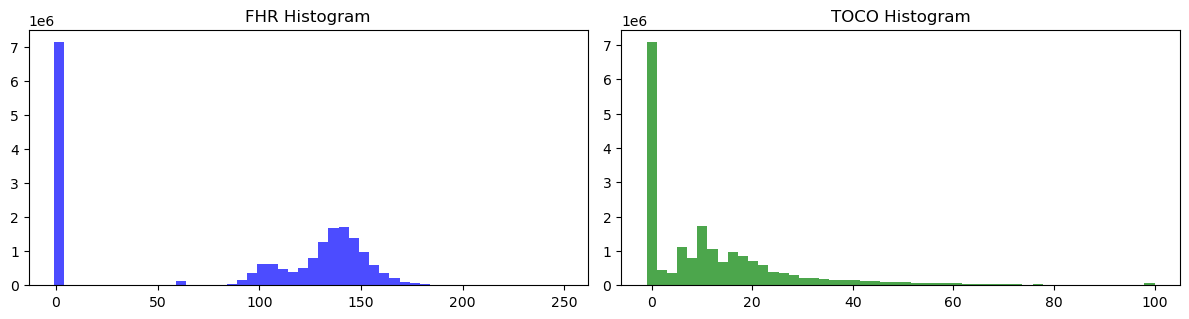

In [3]:
print('FHR range:', np.min(X[:,:,0]), '-', np.max(X[:,:,0]), '; -1s:', np.sum(X[:,:,0] == -1)/X[:,:,0].size)
print('TOCO range:', np.min(X[:,:,1]), '-', np.max(X[:,:,1]), '; -1s:', np.sum(X[:,:,1] == -1)/X[:,:,1].size)

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.hist(X[:, :, 0].flatten(), bins=50, color='blue', alpha=0.7)
plt.title('FHR Histogram')
plt.subplot(2, 2, 2)
plt.hist(X[:, :, 1].flatten(), bins=50, color='green', alpha=0.7)
plt.title('TOCO Histogram')
plt.tight_layout()
plt.show()

----------------------------------- Dataset ------------------------------------
Count: 20589



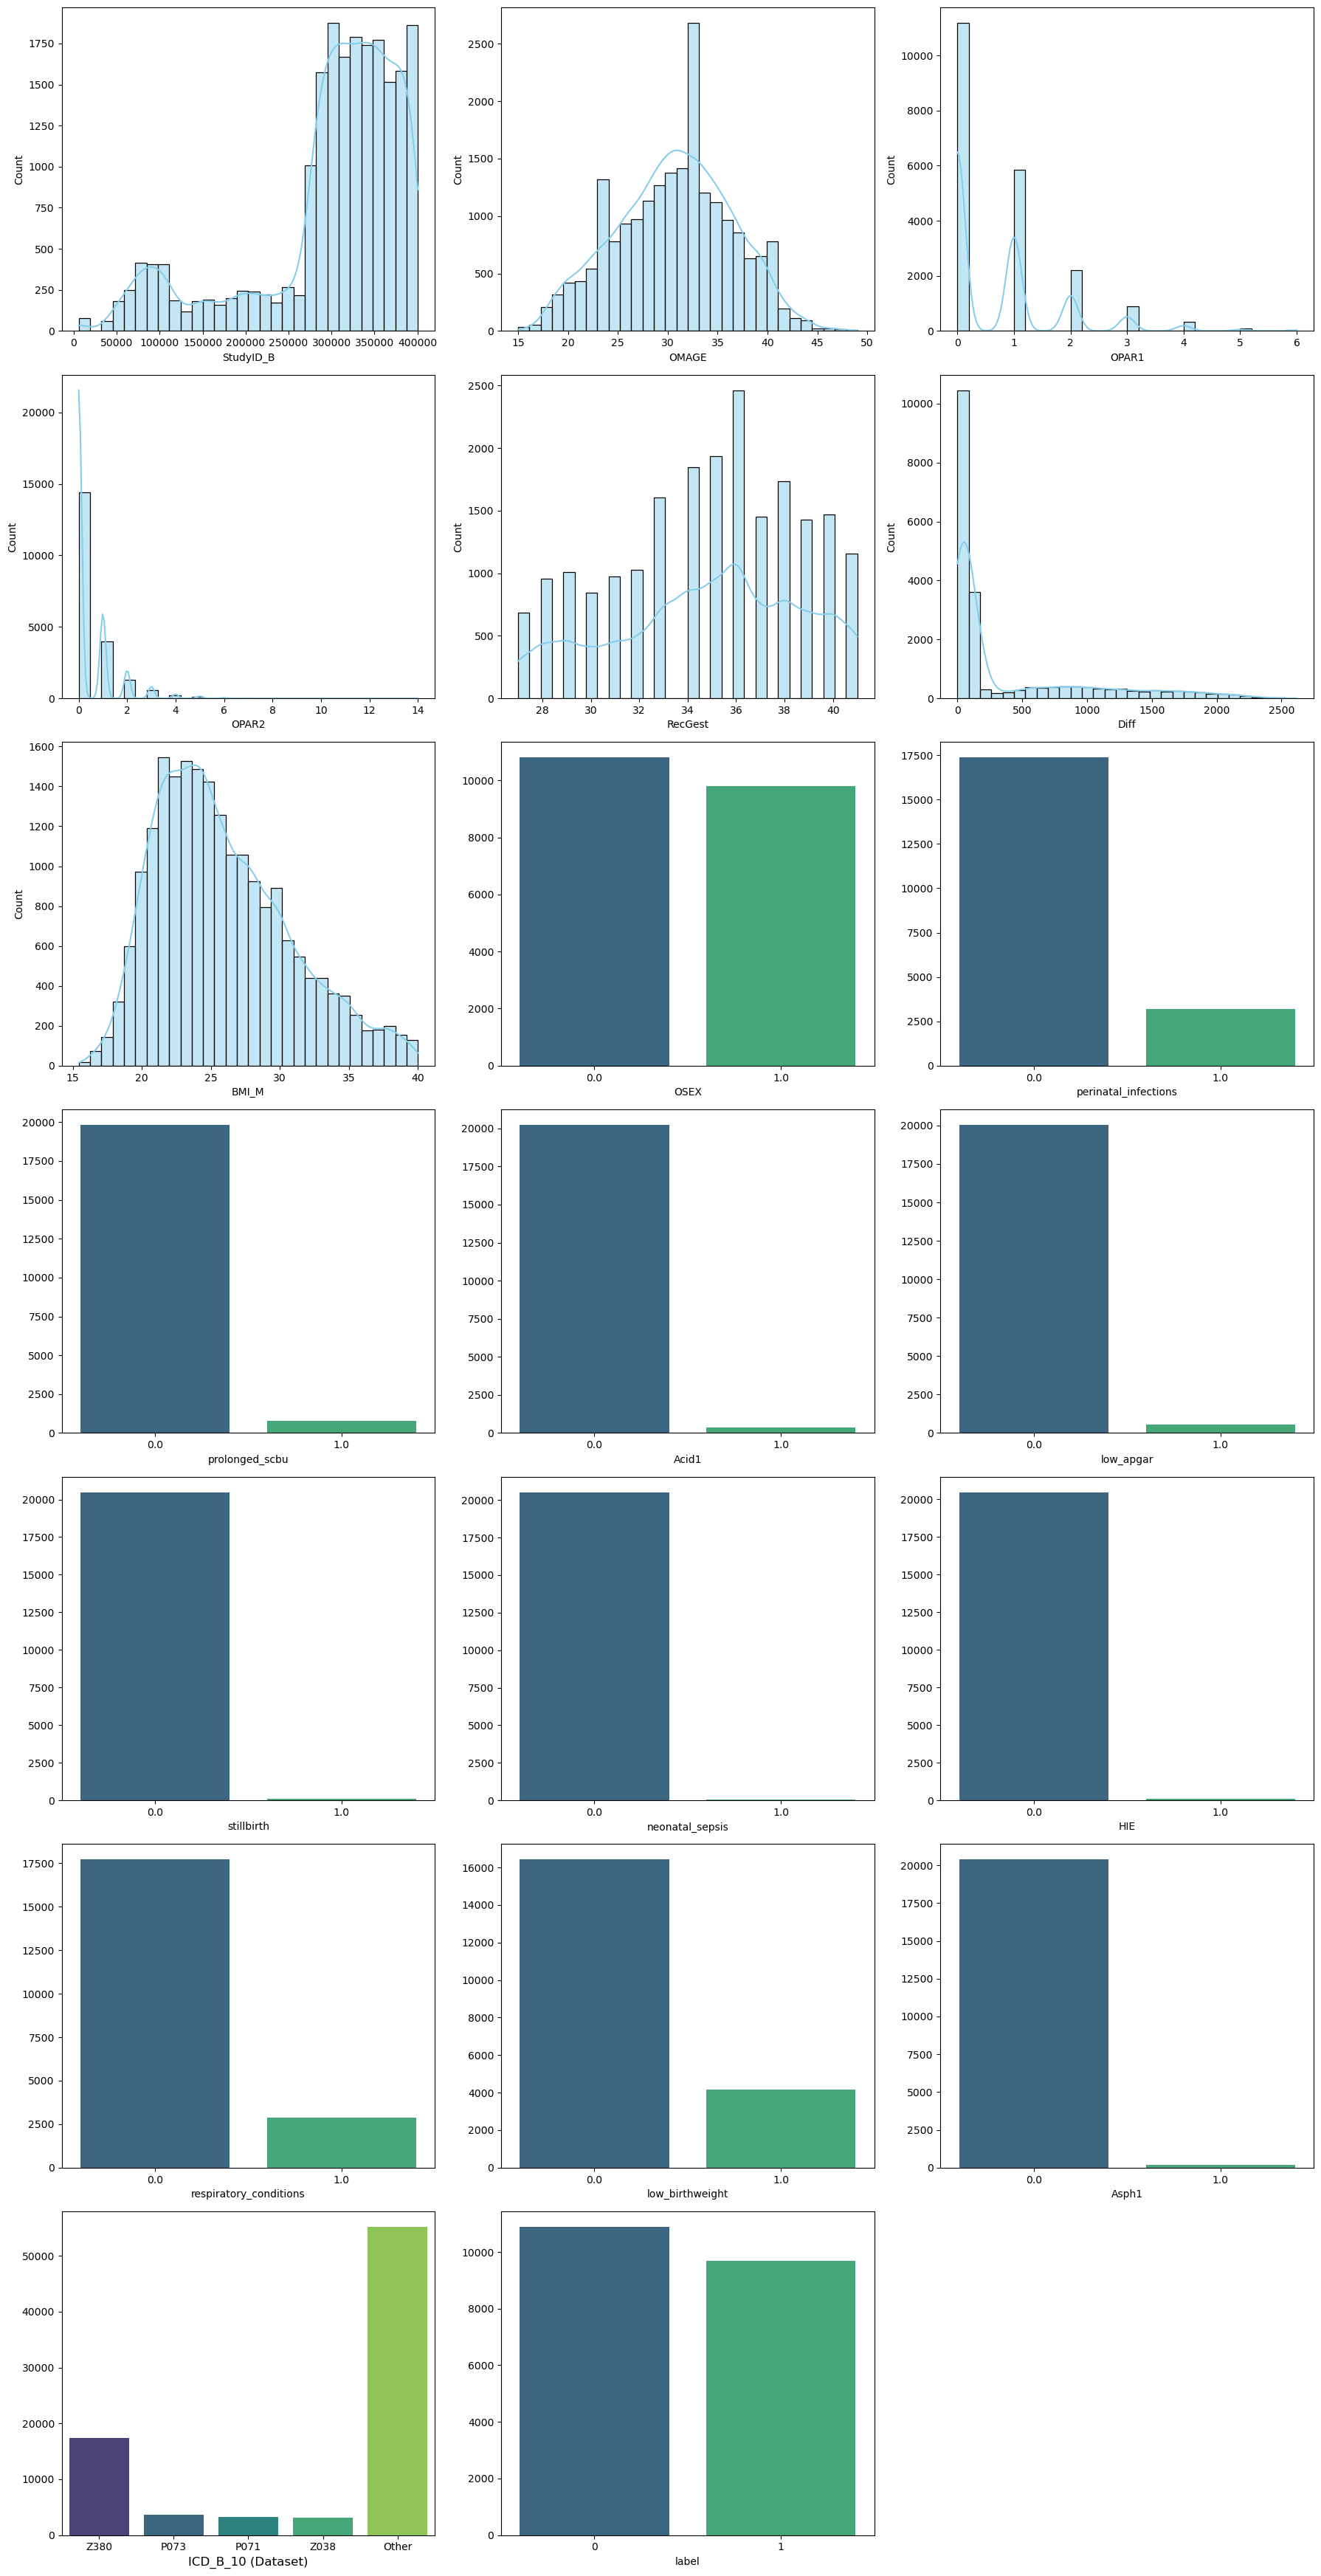

                Column Type/Unique Values                                                                         Details
             StudyID_B            Numeric Min: 5716.00, Max: 400504.00, Mean: 298226.93, Median: 321221.00, Std: 89344.72
                 OMAGE            Numeric                   Min: 15.00, Max: 49.00, Mean: 30.65, Median: 31.00, Std: 5.82
                 OPAR1            Numeric                       Min: 0.00, Max: 6.00, Mean: 0.72, Median: 0.00, Std: 1.00
                 OPAR2            Numeric                      Min: 0.00, Max: 14.00, Mean: 0.47, Median: 0.00, Std: 0.91
               RecGest            Numeric                   Min: 27.00, Max: 41.00, Mean: 34.81, Median: 35.00, Std: 3.85
                  Diff            Numeric               Min: 0.00, Max: 2618.00, Mean: 390.44, Median: 84.00, Std: 580.80
                 BMI_M            Numeric                   Min: 15.42, Max: 40.00, Mean: 25.86, Median: 24.94, Std: 4.85
                  OSEX  

In [4]:
explore_data_results(dataset, plots=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


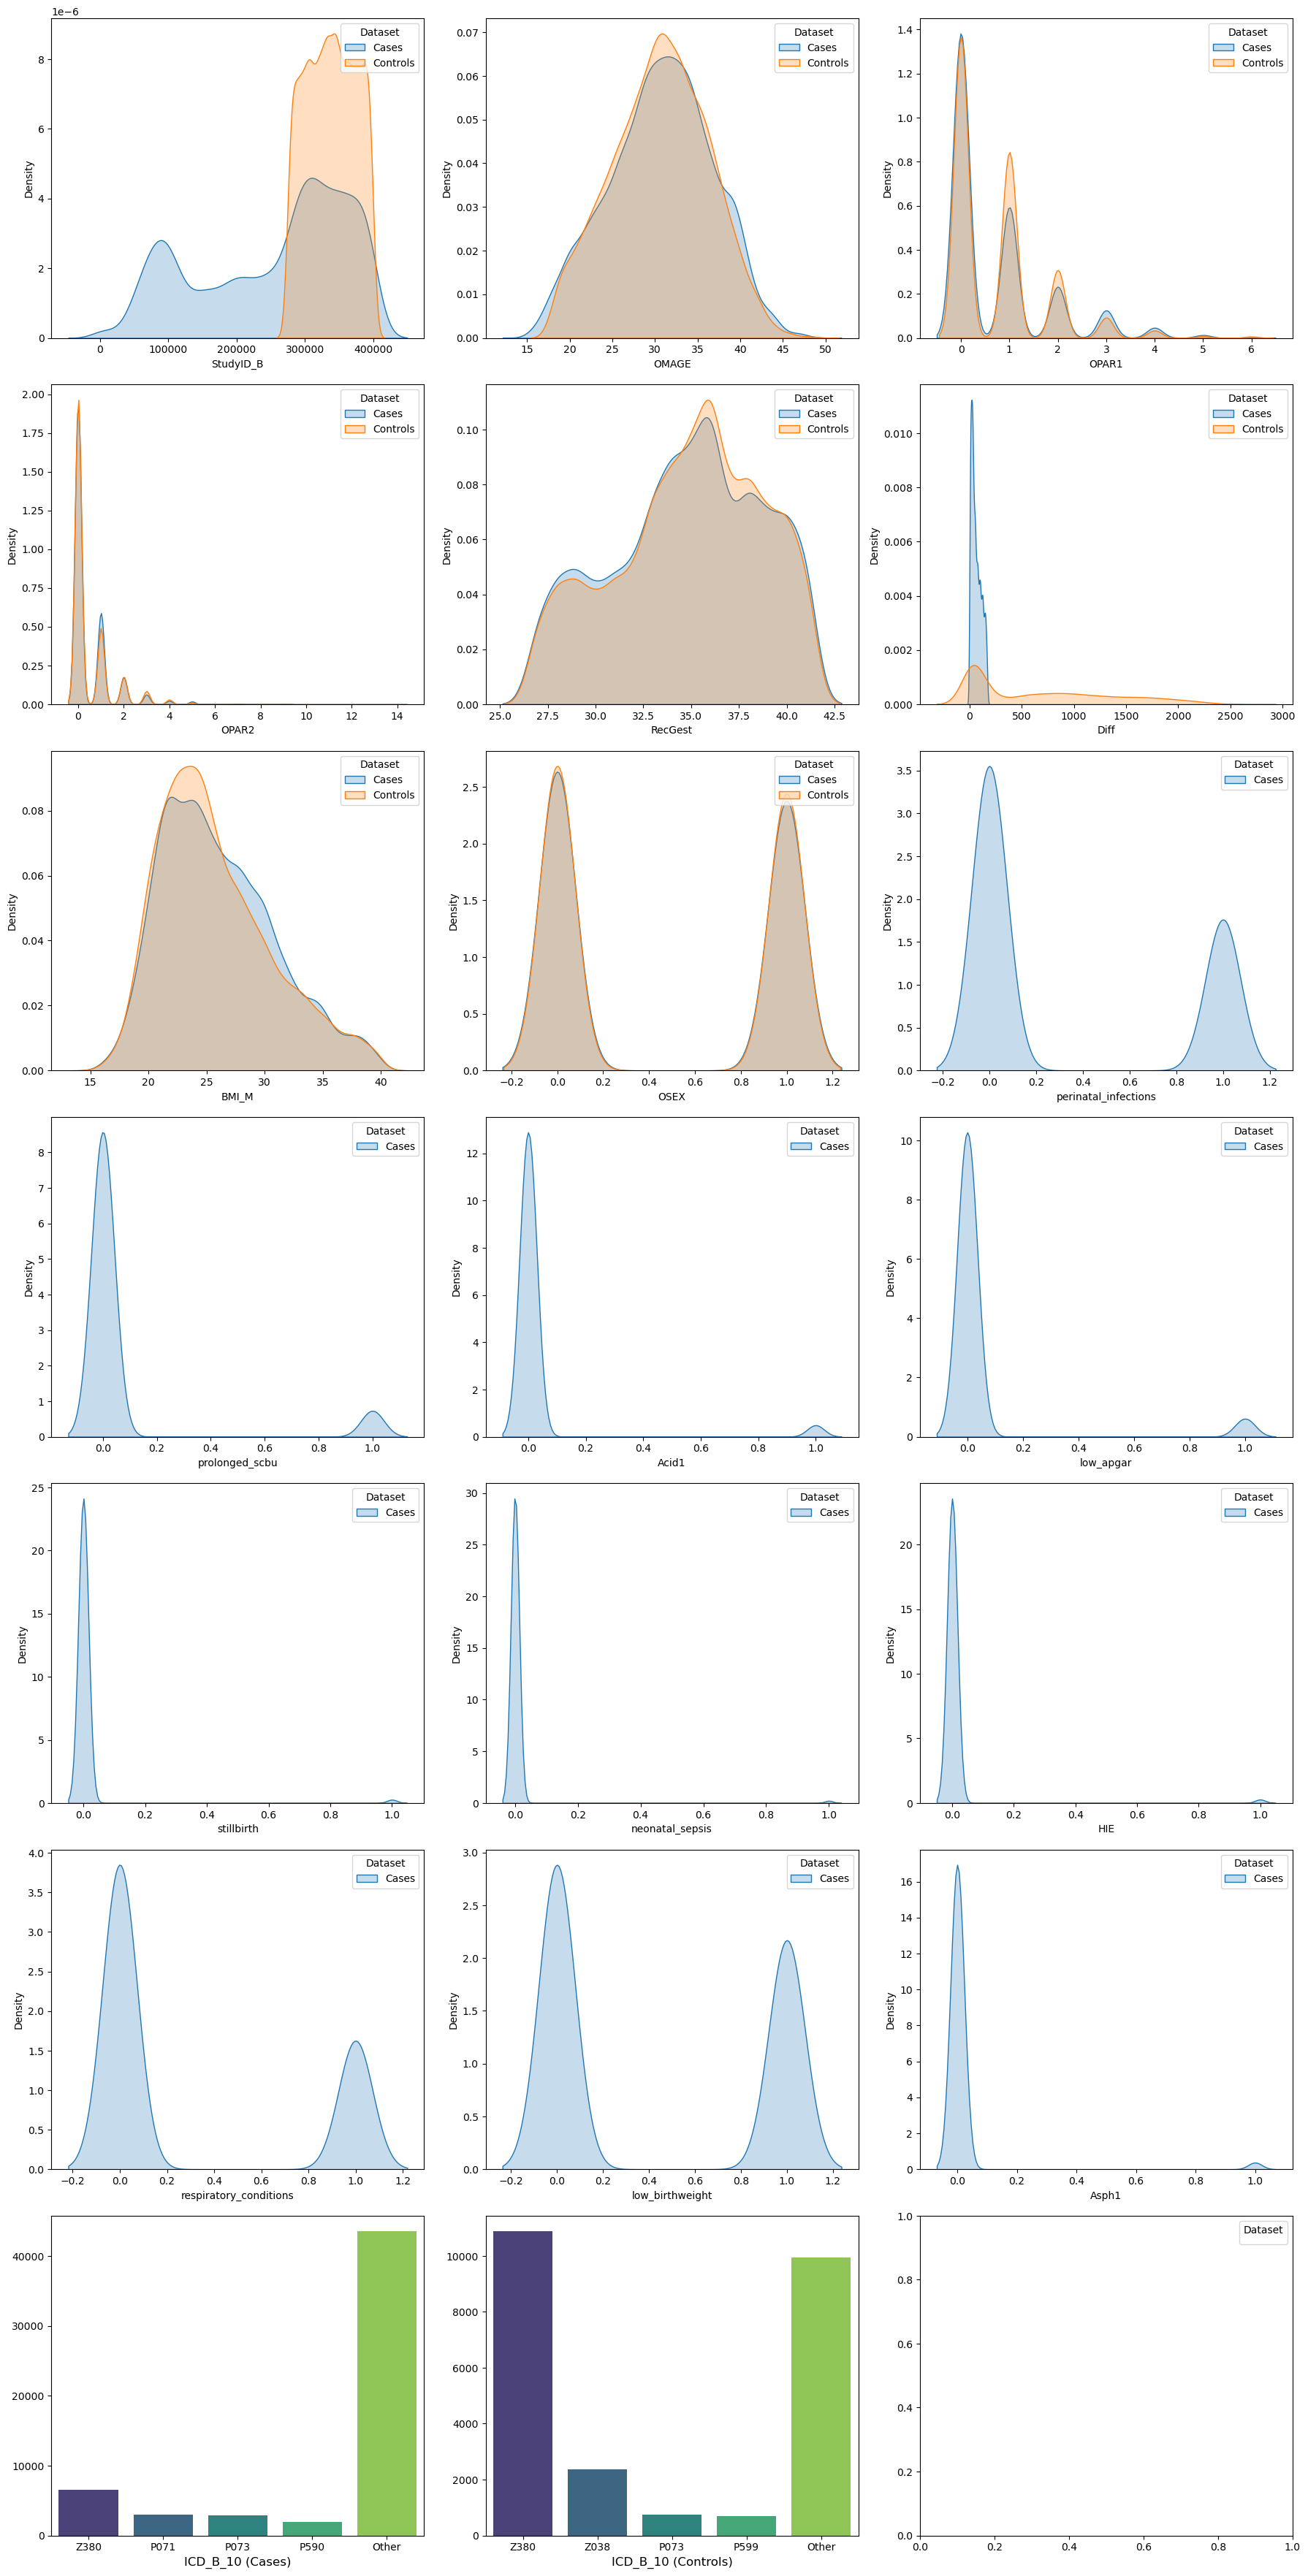

------------------------------------ Cases -------------------------------------
Count: 9699

                Column Type/Unique Values                                                                          Details
             StudyID_B            Numeric Min: 5716.00, Max: 397491.00, Mean: 254018.20, Median: 288414.00, Std: 108764.88
                 OMAGE            Numeric                    Min: 15.00, Max: 49.00, Mean: 30.70, Median: 31.00, Std: 6.02
                 OPAR1            Numeric                        Min: 0.00, Max: 6.00, Mean: 0.71, Median: 0.00, Std: 1.04
                 OPAR2            Numeric                        Min: 0.00, Max: 9.00, Mean: 0.48, Median: 0.00, Std: 0.89
               RecGest            Numeric                    Min: 27.00, Max: 41.00, Mean: 34.76, Median: 35.00, Std: 3.89
                  Diff            Numeric                   Min: 0.00, Max: 168.00, Mean: 62.35, Median: 51.00, Std: 46.92
                 BMI_M            Numeric    

In [5]:
compare_data_results(dataset[dataset['label']==1],dataset[dataset['label']==0], names=['Cases','Controls'])

In [6]:
# Manually set results_dir if needed 
results_dir = None #'PatchTST_supervised/jResults/20240905 1259'

# Set results_dir to the most recent one
if results_dir is None:
    subdirs = [d for d in os.listdir('PatchTST_supervised/jResults/') if os.path.isdir(os.path.join('PatchTST_supervised/jResults/', d))]
    valid_dirs = []
    for subdir in subdirs:
        try:
            datetime.strptime(subdir, '%Y%m%d %H%M')
            valid_dirs.append(subdir)
        except ValueError:
            continue
    valid_dirs_sorted = sorted(valid_dirs, key=lambda x: datetime.strptime(x, '%Y%m%d %H%M'))
    if valid_dirs_sorted:
        results_dir = os.path.join('PatchTST_supervised/jResults/', valid_dirs_sorted[-1])
print(results_dir)

# Load the split dataset, logs and results 
train_df = pd.read_csv(os.path.join(results_dir, 'dataset_train.csv'))
test_df = pd.read_csv(os.path.join(results_dir, 'dataset_test.csv'))
preds = np.load(os.path.join(results_dir, 'preds.npy'))
trues = np.load(os.path.join(results_dir, 'trues.npy'))
with open(os.path.join(results_dir, 'PatchTST_ctg_960.log'), 'r') as log_file:
    log_data = log_file.read()

PatchTST_supervised/jResults/20240905 1259


In [7]:
explore_data_results(train_df, name='train')
explore_data_results(test_df, name='test')

------------------------------------ train -------------------------------------
Count: 16471

                Column Type/Unique Values                                                                         Details
             StudyID_B            Numeric Min: 5716.00, Max: 400504.00, Mean: 297964.03, Median: 320641.00, Std: 89497.00
                 OMAGE            Numeric                   Min: 15.00, Max: 49.00, Mean: 30.64, Median: 31.00, Std: 5.82
                 OPAR1            Numeric                       Min: 0.00, Max: 6.00, Mean: 0.72, Median: 0.00, Std: 1.00
                 OPAR2            Numeric                      Min: 0.00, Max: 14.00, Mean: 0.47, Median: 0.00, Std: 0.91
               RecGest            Numeric                   Min: 27.00, Max: 41.00, Mean: 34.82, Median: 35.00, Std: 3.85
                  Diff            Numeric               Min: 0.00, Max: 2618.00, Mean: 388.44, Median: 82.00, Std: 579.83
                 BMI_M            Numeric          

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


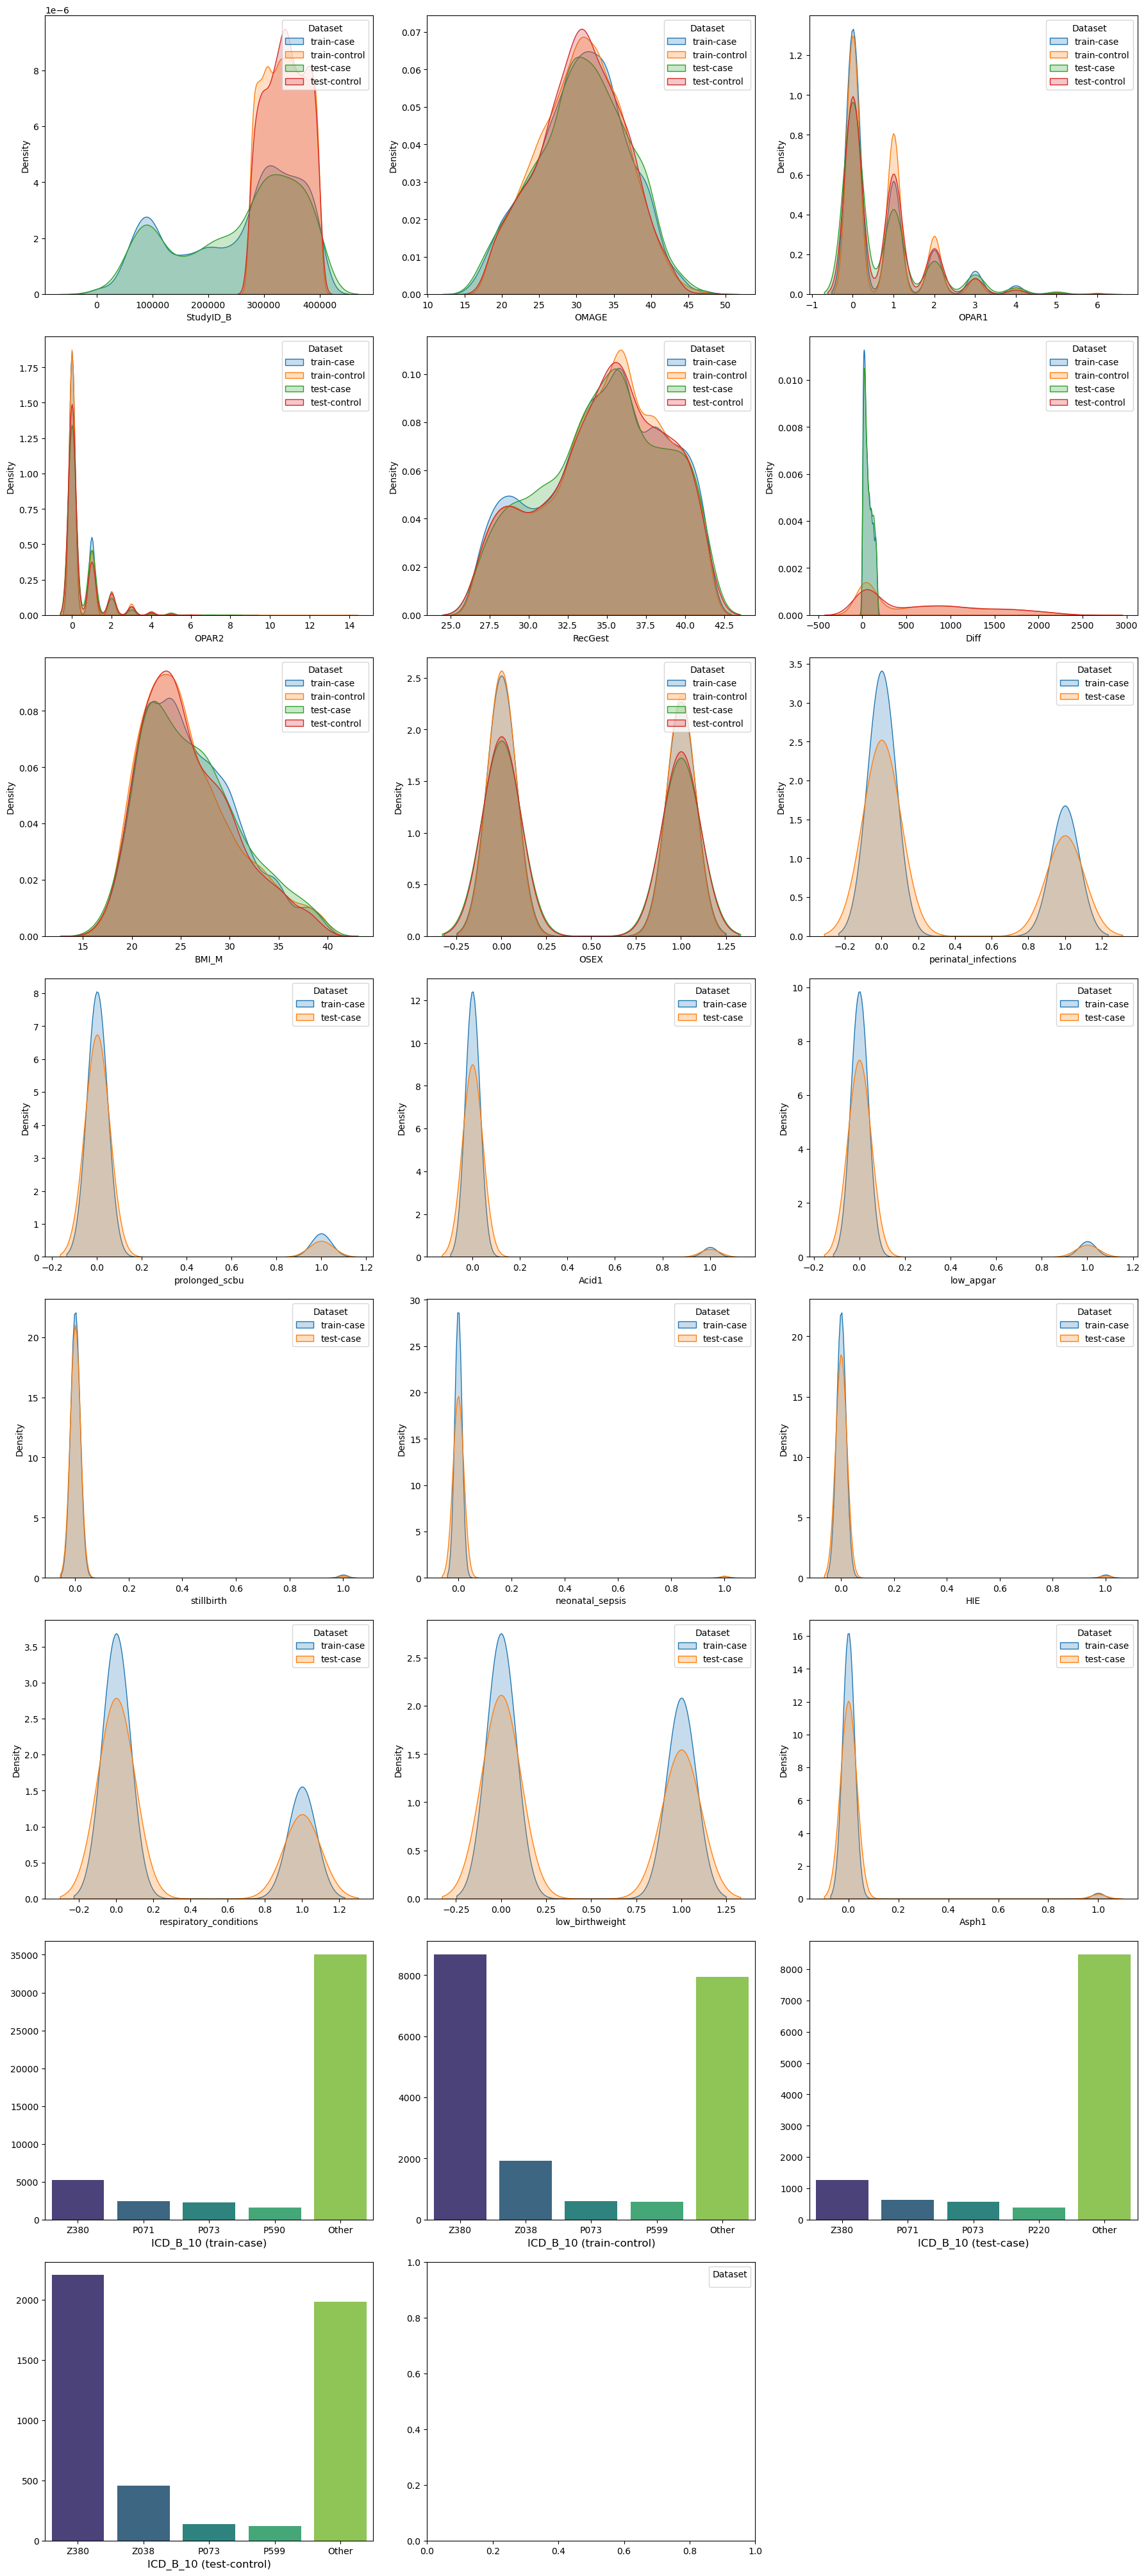

---------------------------------- train-case ----------------------------------
Count: 7787

                Column Type/Unique Values                                                                          Details
             StudyID_B            Numeric Min: 5716.00, Max: 397491.00, Mean: 254073.25, Median: 289015.00, Std: 108931.03
                 OMAGE            Numeric                    Min: 15.00, Max: 49.00, Mean: 30.68, Median: 31.00, Std: 6.00
                 OPAR1            Numeric                        Min: 0.00, Max: 6.00, Mean: 0.70, Median: 0.00, Std: 1.04
                 OPAR2            Numeric                        Min: 0.00, Max: 9.00, Mean: 0.47, Median: 0.00, Std: 0.89
               RecGest            Numeric                    Min: 27.00, Max: 41.00, Mean: 34.77, Median: 35.00, Std: 3.90
                  Diff            Numeric                   Min: 0.00, Max: 168.00, Mean: 61.87, Median: 50.00, Std: 46.81
                 BMI_M            Numeric    

In [8]:
compare_data_results(train_df[train_df['label']==1],train_df[train_df['label']==0], 
                     test_df[test_df['label']==1],test_df[test_df['label']==0],
                     names=['train-case','train-control','test-case','test-control'])

******************** Hyperparameters ********************
activation: gelu
affine: 0
batch_size: 64
c_out: 1
checkpoints: ./checkpoints/ctg
d_ff: 256
d_layers: 1
d_model: 128
data: CTG
data_path: X.npy
dec_in: 2
decomposition: 0
des: Exp
devices: 0,1,2,3
distil: True
do_predict: False
dropout: 0.4
e_layers: 3
embed: timeF
embed_type: 0
enc_in: 2
factor: 1
fc_dropout: 0.2
features: M
freq: h
gpu: 0
head_dropout: 0.0
individual: 0
is_training: 1
itr: 1
kernel_size: 25
learning_rate: 5e-05
loss: cross_entropy
lradj: type3
model: PatchTST
model_id: ctg_960
moving_avg: 25
n_heads: 16
num_classes: 2
num_workers: 10
output_attention: False
padding_patch: end
patch_len: 16
patience: 30
pct_start: 0.3
random_seed: 2021
revin: 1
root_path: ./dataset/
seq_len: 960
stride: 8
subtract_last: 0
target: OT
test_flop: False
train_epochs: 200
use_amp: False
use_gpu: True
use_multi_gpu: False

******************* Training Results ********************

Total Training Time: 0:36:03.800773


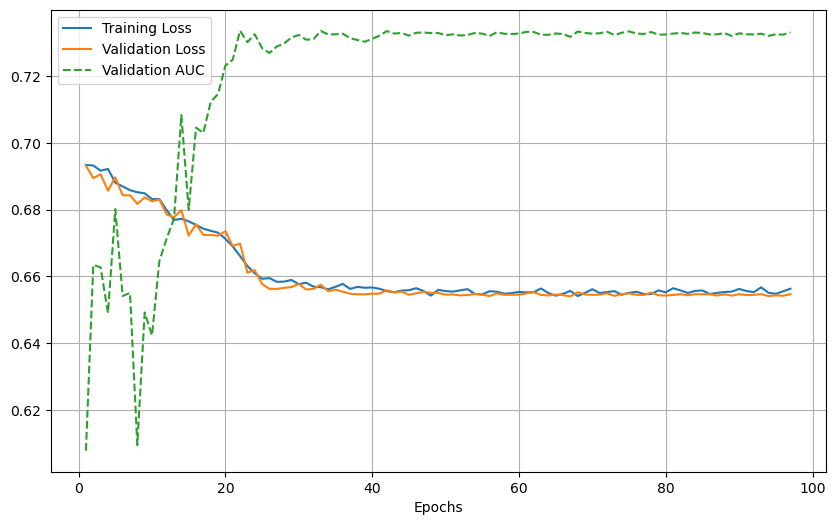


******************** Testing Results ********************
Accuracy: 0.65
Precision: 0.88
Recall: 0.29
F1 Score: 0.43
AUC: 0.73


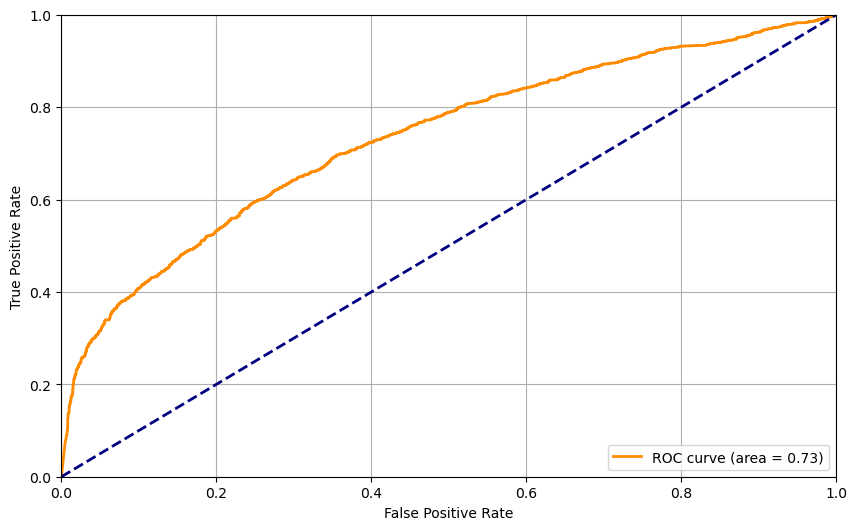

In [9]:
# Initialize variables to store log data
hyperparameters = {}
train_losses = []
val_losses = []
val_aucs = []
epochs = []
train_times = []
test_metrics = None

# Parse the log data directly from the variable
lines = log_data.splitlines()
for i, line in enumerate(lines):
    if i == 1 and line.startswith("Namespace("):
        hyperparameter_string = line.strip().replace("Namespace(", "").replace(")", "")
        hyperparameter_pairs = hyperparameter_string.split(", ")
        for item in hyperparameter_pairs:
            if "=" in item:
                key, value = item.split("=", 1)
                hyperparameters[key.strip()] = value.strip().strip("'")  # Remove quotes around string values

    # Extract training/validation losses and validation auc
    if "Train Loss" in line:
        match = re.findall(r'Epoch: (\d+).*Train Loss: ([\d.]+) Vali Loss: ([\d.]+) Vali AUC: ([\d.]+)', line)
        if match:
            epoch, train_loss, val_loss, val_auc = match[0]
            epochs.append(int(epoch))
            train_losses.append(float(train_loss))
            val_losses.append(float(val_loss))
            val_aucs.append(float(val_auc))
    
    # Extract training time
    if "cost time" in line:
        match = re.findall(r'Epoch: (\d+) cost time: ([\d.]+)', line)
        if match:
            epoch, time_taken = match[0]
            train_times.append(float(time_taken))
    
    # Extract final test metrics
    if "accuracy" in line:
        match = re.findall(r'accuracy:([\d.]+), precision:([\d.]+), recall:([\d.]+), f1:([\d.]+), auc:([\d.]+)', line)
        if match:
            accuracy, precision, recall, f1, auc_score = match[0]
            test_metrics = {
                'Accuracy': float(accuracy),
                'Precision': float(precision),
                'Recall': float(recall),
                'F1 Score': float(f1),
                'AUC': float(auc_score)
            }

print("******************** Hyperparameters ********************")
for key, value in hyperparameters.items():
    print(f"{key}: {value}")

print("\n******************* Training Results ********************")

# Calculate and print total training time
total_train_time = sum(train_times)
train_time_hms = str(timedelta(seconds=total_train_time))
print(f"\nTotal Training Time: {train_time_hms}")

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.plot(epochs, val_aucs, label='Validation AUC', linestyle='--')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Print the final test results
if test_metrics:
    print("\n******************** Testing Results ********************")
    for metric, value in test_metrics.items():
        print(f"{metric}: {np.round(value, decimals=2)}")

# Compute ROC curve and AUC using already loaded preds and trues
fpr, tpr, _ = roc_curve(trues, preds)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


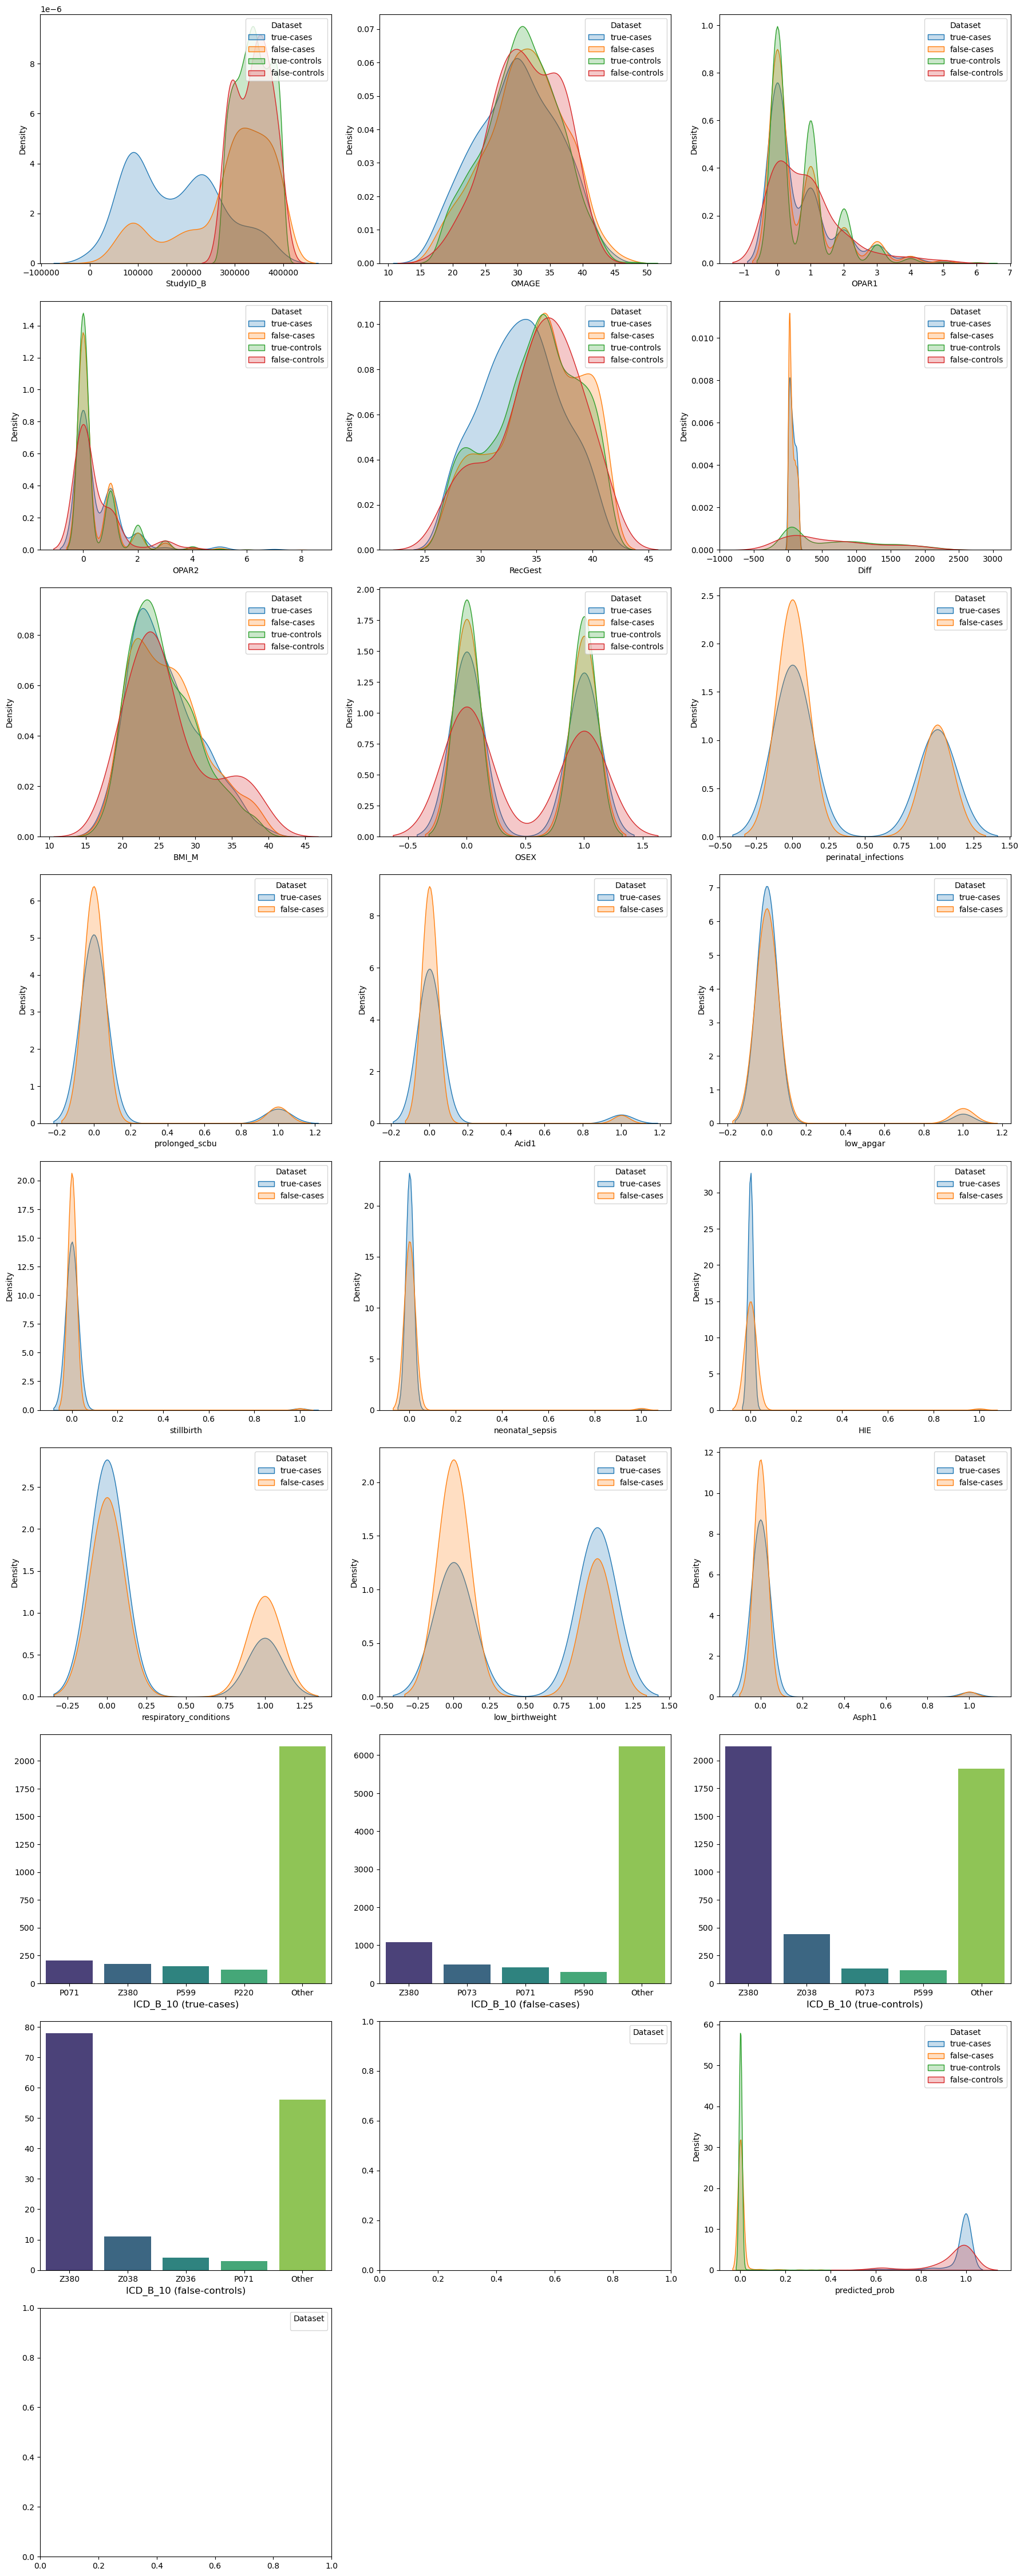

---------------------------------- true-cases ----------------------------------
Count: 549

                Column Type/Unique Values                                                                         Details
             StudyID_B            Numeric Min: 5716.00, Max: 391564.00, Mean: 177372.87, Median: 167314.00, Std: 95201.61
                 OMAGE            Numeric                   Min: 16.00, Max: 44.00, Mean: 29.89, Median: 30.00, Std: 6.17
                 OPAR1            Numeric                       Min: 0.00, Max: 5.00, Mean: 0.74, Median: 0.00, Std: 1.06
                 OPAR2            Numeric                       Min: 0.00, Max: 7.00, Mean: 0.58, Median: 0.00, Std: 1.00
               RecGest            Numeric                   Min: 27.00, Max: 41.00, Mean: 33.62, Median: 34.00, Std: 3.51
                  Diff            Numeric                  Min: 1.00, Max: 168.00, Mean: 68.11, Median: 60.00, Std: 47.42
                 BMI_M            Numeric            

In [10]:
# Add the results to test_df
predicted_probs = preds.flatten()
predicted_labels = (predicted_probs > 0.5).astype(int)
test_df = test_df[:len(preds)]
test_df['predicted_prob'] = predicted_probs
test_df['predicted_label'] = predicted_labels

# Filtering by correctly classified and misclassified samples, as well as by label
correctly_classified_cases = test_df[(test_df['label'] == 1) & (test_df['label'] == test_df['predicted_label'])]
correctly_classified_controls = test_df[(test_df['label'] == 0) & (test_df['label'] == test_df['predicted_label'])]
misclassified_cases = test_df[(test_df['label'] == 1) & (test_df['label'] != test_df['predicted_label'])]
misclassified_controls = test_df[(test_df['label'] == 0) & (test_df['label'] != test_df['predicted_label'])]

compare_data_results(correctly_classified_cases, misclassified_cases,
                     correctly_classified_controls, misclassified_controls,
                     names=['true-cases','false-cases','true-controls','false-controls'])

In [11]:
def calculate_stats(data, name):
    print(f"------ Stats of {name} ({len(data)}) -----")
    # Filter numeric columns
    numeric_columns = data.select_dtypes(include=['number']).columns
    columns_of_interest = [col for col in numeric_columns if col not in ['input_signals', 'label', 'predicted_prob', 'predicted_label']]
    
    # Calculate min, max, mean specifically for numeric columns
    stats = data[columns_of_interest].agg(['min', 'max', 'mean']).round(2)
    print(stats)
    print("\n")

calculate_stats(test_df, "All Test Samples")
calculate_stats(correctly_classified_cases, "Correctly Classified Cases")
calculate_stats(misclassified_cases, "Misclassified Cases")
calculate_stats(correctly_classified_controls, "Correctly Classified Controls")
calculate_stats(misclassified_controls, "Misclassified Controls")

------ Stats of All Test Samples (4118) -----
      StudyID_B  OMAGE  OPAR1  OPAR2  RecGest     Diff  BMI_M  OSEX  \
min     5716.00  16.00   0.00   0.00    27.00     0.00  15.73  0.00   
max   399217.00  48.00   6.00   8.00    41.00  2517.00  39.82  1.00   
mean  299278.43  30.71   0.74   0.48    34.79   398.45  25.89  0.48   

      perinatal_infections  prolonged_scbu  Acid1  low_apgar  stillbirth  \
min                   0.00            0.00   0.00       0.00         0.0   
max                   1.00            1.00   1.00       1.00         1.0   
mean                  0.16            0.03   0.02       0.03         0.0   

      neonatal_sepsis  HIE  respiratory_conditions  low_birthweight  Asph1  
min               0.0  0.0                    0.00              0.0   0.00  
max               1.0  1.0                    1.00              1.0   1.00  
mean              0.0  0.0                    0.14              0.2   0.01  


------ Stats of Correctly Classified Cases (549) -----

Diff < 168: AUC: 0.73, Accuracy: 0.65, Precision: 0.87, Recall: 0.29, F1-score: 0.43
Diff < 144: AUC: 0.73, Accuracy: 0.66, Precision: 0.87, Recall: 0.29, F1-score: 0.43
Diff < 120: AUC: 0.73, Accuracy: 0.68, Precision: 0.85, Recall: 0.28, F1-score: 0.42
Diff < 96: AUC: 0.73, Accuracy: 0.70, Precision: 0.83, Recall: 0.28, F1-score: 0.41
Diff < 72: AUC: 0.72, Accuracy: 0.72, Precision: 0.80, Recall: 0.26, F1-score: 0.40
Diff < 48: AUC: 0.71, Accuracy: 0.76, Precision: 0.74, Recall: 0.26, F1-score: 0.38
Diff < 24: AUC: 0.70, Accuracy: 0.84, Precision: 0.59, Recall: 0.24, F1-score: 0.35


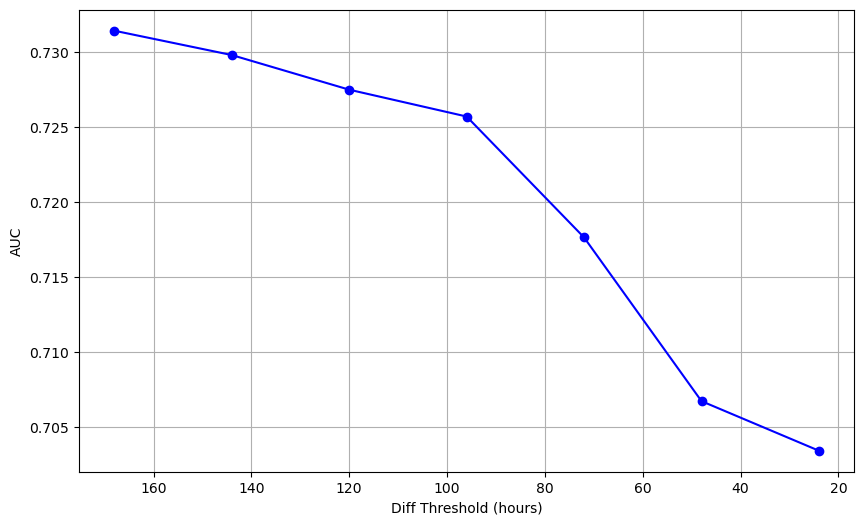

In [12]:
def calculate_f1(precision, recall):
    return 2 * (precision * recall) / (precision + recall)

# List of thresholds for 'Diff'
thresholds = [7*24, 6*24, 5*24, 4*24, 3*24, 2*24, 1*24]

auc_values = []

# Iterate over thresholds to evaluate the performance
for threshold in thresholds:
    subset_df = test_df[(test_df['label'] == 0) | ((test_df['label'] == 1) & (test_df['Diff'] < threshold))]
    subset_name = f"Diff < {threshold}"
    
    y_pred_classes_optimized = np.array(subset_df['predicted_label'].values)
    y_pred_prob = np.array(subset_df['predicted_prob'].values).ravel()
    y_true = np.array(subset_df['label'].values).astype(int)

    auc = roc_auc_score(y_true, y_pred_prob)
    accuracy = accuracy_score(y_true, y_pred_classes_optimized)
    precision = precision_score(y_true, y_pred_classes_optimized)
    recall = recall_score(y_true, y_pred_classes_optimized)
    f1 = calculate_f1(precision, recall)

    auc_values.append(auc)
    
    print(f"{subset_name}: AUC: {auc:.2f}, Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")

# Plotting the AUC values against the thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, auc_values, marker='o', linestyle='-', color='b')
plt.xlabel('Diff Threshold (hours)')
plt.ylabel('AUC')
plt.gca().invert_xaxis()  # Invert x-axis to show decreasing thresholds from left to right
plt.grid(True)
plt.show()